# MLP Double lesion Test - Stability! Experimenting Plots!

In [1]:
MODEL_TAG = 'FASHION+DROPOUT'
MODE = 'STORE'
WITH_ONE_WAY_RANDOM_DEMO = False
MODEL_NUMBER = 1
FILTER = 'all'
MODEL_BASE_PATH = '../models/'

In [2]:
assert MODE in ('STORE', 'LOAD')
assert MODEL_NUMBER > 0

In [3]:
%load_ext autoreload
%autoreload 2

In [62]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
sys.path.append('..')

import pickle

from IPython import display
from tqdm import tqdm
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

from src.pointers import DATA_PATHS
from src.experiment_tagging import get_model_path
from src.lesion import (perform_lesion_experiment,
                              report_lesion_test,
                              compute_damaged_cluster_stats,
                              plot_overall_damaged_clusters)
from src.visualization import (run_double_spectral_cluster, draw_mlp_clustering_report,
                               build_weighted_dist_mat, plot_weighted_dist_mat,
                               draw_ow_weight_dependency_graph)

sns.set(style='whitegrid')

In [86]:
model_path = get_model_path(MODEL_TAG, filter_=FILTER, model_base_path=MODEL_BASE_PATH)[-MODEL_NUMBER]


DATASET_NAME, *_ = MODEL_TAG.split('+')
DATASET_NAME = DATASET_NAME.lower()

PICKLE_PATH = f'../results/double-lesion-{MODEL_TAG}-{MODEL_NUMBER}-stability-publication.pickle'

In [6]:
if MODE == 'LOAD':
    with open(PICKLE_PATH, 'rb') as f:
        (N_CLUSTERS, single_df,
         TWO_WAY_N_SHUFFLES, TWO_WAY_PVALUE_THRESHOLD,
         double_joint_df, joint_metadata, 
         double_conditional_df, conditional_metadata) = pickle.load(f)
        
if MODE == 'STORE':
    N_CLUSTERS = 10
    TWO_WAY_N_SHUFFLES = 50
    TWO_WAY_PVALUE_THRESHOLD = 1 / TWO_WAY_N_SHUFFLES

## Clustering

CPU times: user 1min 8s, sys: 1min 31s, total: 2min 40s
Wall time: 25 s


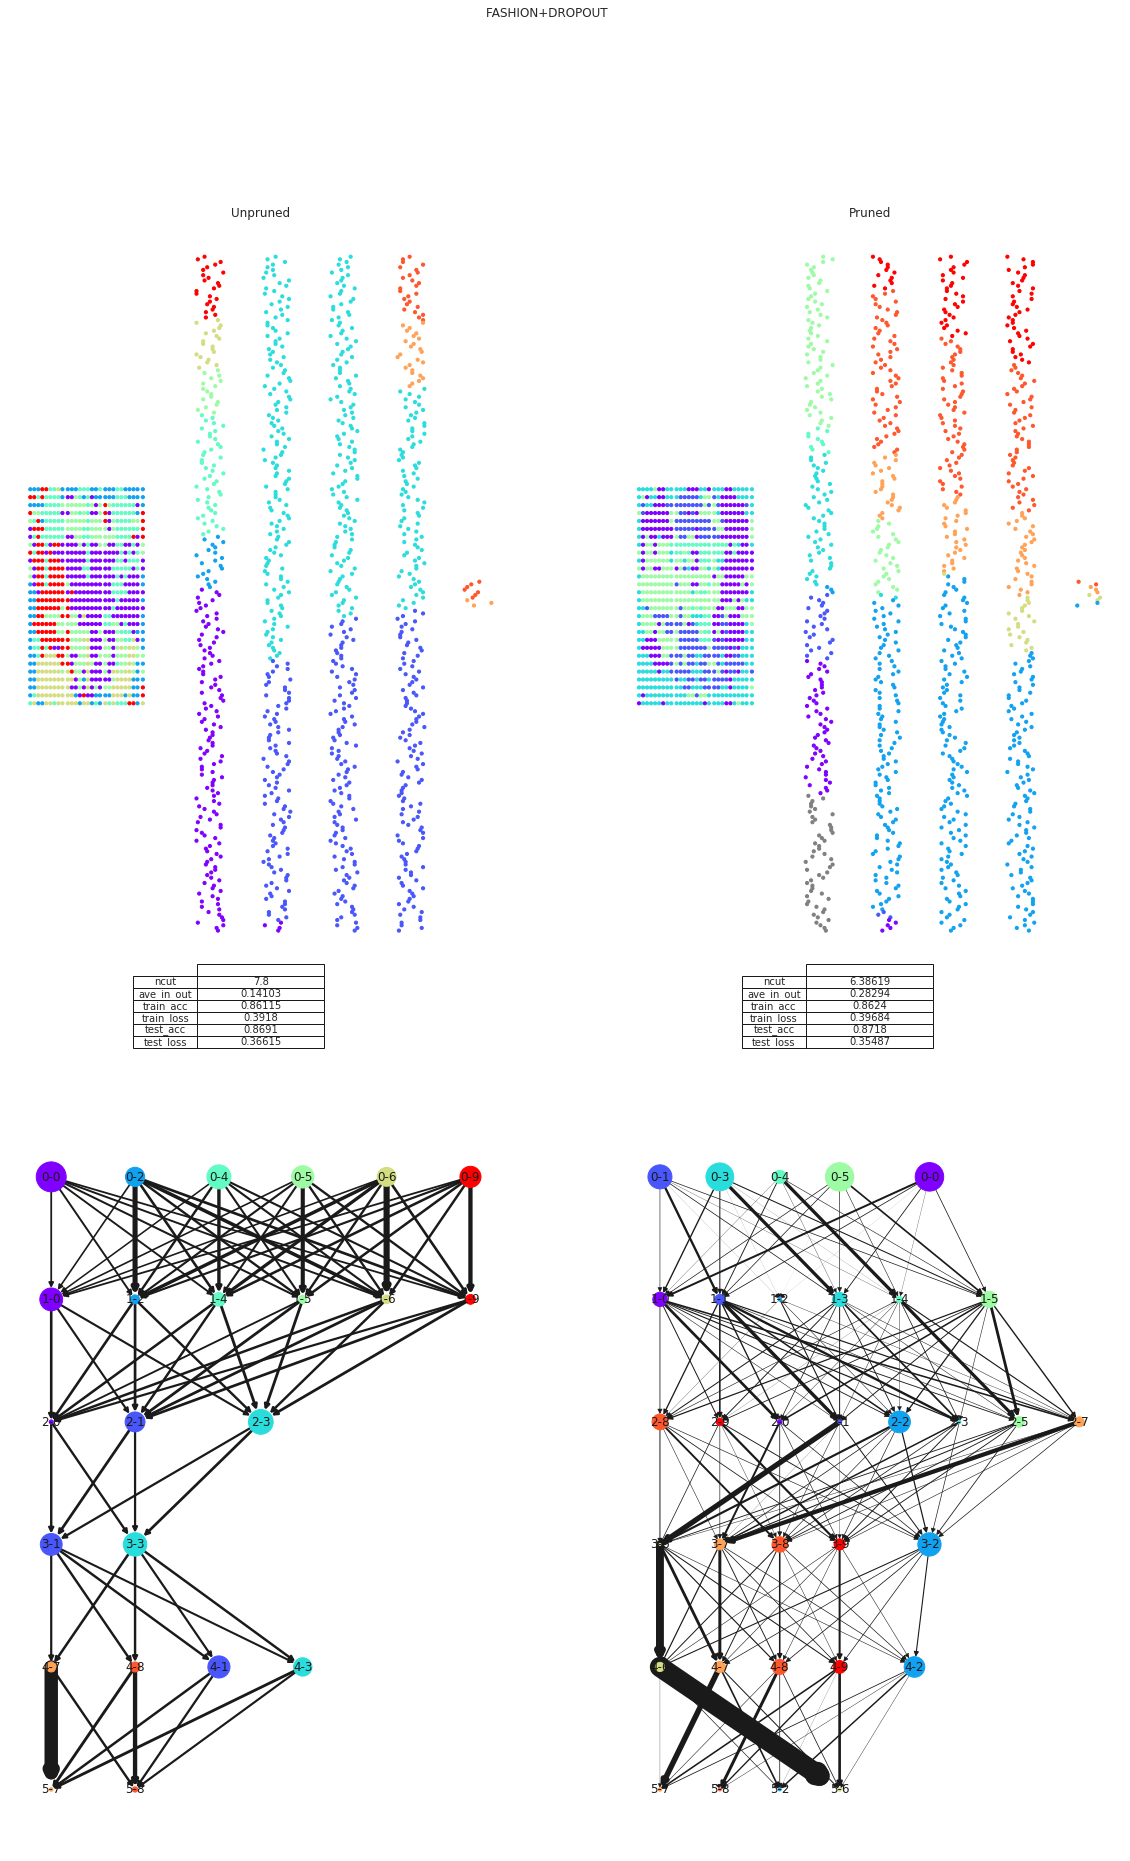

In [7]:
%%time

one_way_clustering_result = run_double_spectral_cluster(model_path, n_clusters=N_CLUSTERS, with_shuffle=False)

draw_mlp_clustering_report(model_path,
                           one_way_clustering_result,
                           n_cluster=N_CLUSTERS, title=f'{MODEL_TAG}')

## Single: Taxonomy of layer-clusters

%%time

if MODE == 'STORE':
    single_df = report_lesion_test(MODEL_TAG,
                                     '.' + DATA_PATHS[DATASET_NAME],
                                     model_path,
                                     n_clusters=N_CLUSTERS, n_shuffles=100, n_way=1,
                                     verbose=True)

In [8]:
%%time

(true_results,
 all_random_results,
 metadata,
 evaluation) = perform_lesion_experiment('.' + DATA_PATHS['fashion'],
                                               model_path, n_clusters=N_CLUSTERS,
                                               n_shuffles=100)

CPU times: user 47min 26s, sys: 5min 34s, total: 53min 1s
Wall time: 22min 16s


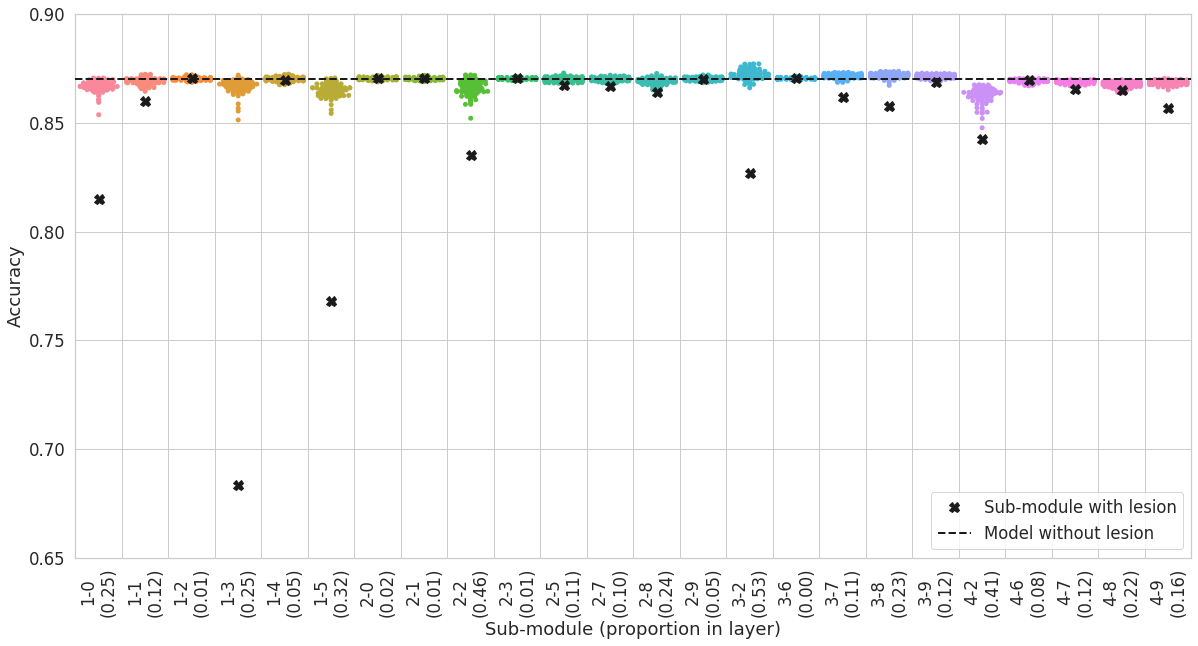

In [173]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

plot_overall_damaged_clusters(true_results, all_random_results, metadata, evaluation, figsize=(20, 10),
                             y_lim=(0.65, 0.9))
plt.legend(loc='lower right')

plt.savefig('../plots/mlp-single-lestion-test-accuracies-with-random.png', dpi=300)

In [225]:
single_df = compute_damaged_cluster_stats(true_results, all_random_results, metadata, evaluation)

single_df

diff  corrected_pvalue  label_in_layer_proportion    true  \
layer label                                                                
1     0     -0.0552          0.009901                   0.250000  0.8151   
      1     -0.0105          0.009901                   0.122549  0.8598   
      2      0.0002          0.643564                   0.014706  0.8705   
      3     -0.1870          0.009901                   0.245098  0.6833   
      4     -0.0005          0.376238                   0.049020  0.8698   
      5     -0.1024          0.009901                   0.318627  0.7679   
2     0      0.0001          0.524752                   0.019531  0.8704   
      1      0.0001          0.554455                   0.011719  0.8704   
      2     -0.0350          0.009901                   0.460938  0.8353   
      3      0.0002          0.712871                   0.007812  0.8705   
      5     -0.0027          0.019802                   0.109375  0.8676   
      7     -0.0033          0.009901                   0.097656  0.8670   
      8     -0.0063          0.009901                   0.242188  0.8640   
      9     -0.0002          0.386139                   0.050781  0.8701   
3     2     -0.0433          0.009901                   0.527344  0.8270   
      6      0.0001          0.554455                   0.003906  0.8704   
      7     -0.0085          0.009901                   0.113281  0.8618   
      8     -0.0127          0.009901                   0.234375  0.8576   
      9     -0.0016          0.009901                   0.121094  0.8687   
4     2     -0.0279          0.009901                   0.414062  0.8424   
      6     -0.0006          0.693069                   0.082031  0.8697   
      7     -0.0049          0.009901                   0.125000  0.8654   
      8     -0.0054          0.059406                   0.218750  0.8649   
      9     -0.0136          0.009901                   0.160156  0.8567   

                     taxonomy      mean       std    z_score  n_layer_label  
layer label                                                                  
1     0             important  0.866863  0.002587 -20.012685             51  
      1             important  0.869211  0.001547  -6.083256             25  
      2                 small  0.870233  0.000570   0.468742              3  
      3             important  0.866641  0.003085 -59.420469             50  
      4                 small  0.870076  0.000995  -0.277260             10  
      5             important  0.865052  0.002973 -32.680056             65  
2     0                 small  0.870314  0.000514   0.167235              5  
      1                 small  0.870314  0.000515   0.166980              3  
      2             important  0.866087  0.003411  -9.026677            118  
      3                 small  0.870297  0.000313   0.647556              2  
      5                 other  0.869866  0.001044  -2.170692             28  
      7      sig-but-not-diff  0.869989  0.000945  -3.162812             25  
      8      sig-but-not-diff  0.868998  0.001557  -3.210963             62  
      9                 other  0.870239  0.000736  -0.188876             13  
3     2             important  0.872215  0.002140 -21.124612            135  
      6                 small  0.870366  0.000271   0.125688              1  
      7      sig-but-not-diff  0.871403  0.001023  -9.386067             29  
      8             important  0.871753  0.001145 -12.357004             60  
      9      sig-but-not-diff  0.871257  0.000887  -2.882844             31  
4     2             important  0.862700  0.003484  -5.826654            106  
      6                 other  0.869262  0.000716   0.612078             21  
      7      sig-but-not-diff  0.868745  0.000827  -4.044187             32  
      8                 other  0.867445  0.001395  -1.824699             56  
      9             important  0.868415  0.001010 -11.603745             41

In [226]:
single_df.to_csv('../results/mlp-single-lesion-fashion-dropout-publication.csv')

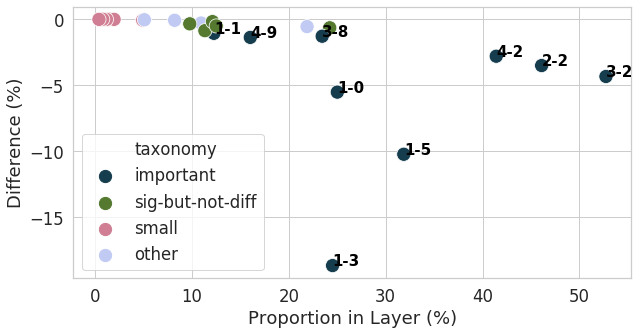

In [177]:
from src.lesion.output import plot_cluster_scatter

plot_cluster_scatter(single_df);

plt.savefig('../plots/mlp-single-lestion-test-clusters.png', dpi=300)

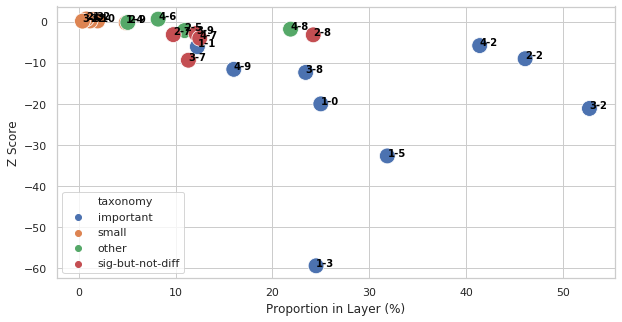

In [11]:
plot_cluster_scatter(single_df, y='z_score');

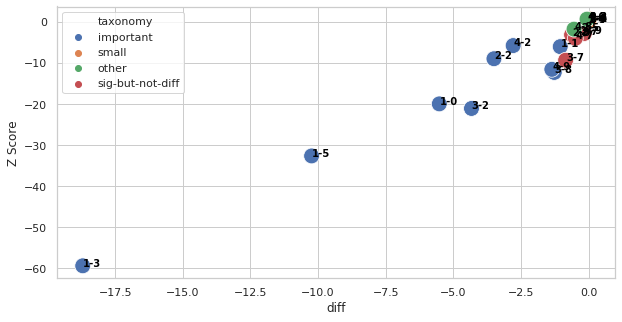

In [12]:
plot_cluster_scatter(single_df, x='diff', y='z_score');

#### Let's look on a random clustering

In [13]:
if WITH_ONE_WAY_RANDOM_DEMO:
    ax = plot_cluster_scatter(report_lesion_test(MODEL_TAG,
                                             '.' + DATA_PATHS[DATASET_NAME],
                                             model_path,
                                             n_clusters=N_CLUSTERS, n_shuffles=100, n_way=1,
                                             with_overall_plot=False, with_accuracy_profile=False,
                                             true_as_random=True,
                                             verbose=False),
                        vmin=-13)

    ax.set_ylim(-13, 1);

## Double: Exploring Dependencies between layer-clusters

In [14]:
from src.lesion.output import (build_double_mat,
                                     build_double_joint_interaction_mat,
                                     build_conditional_double_df,
                                     plot_double_heatmap,
                                     compute_damaged_cluster_stats,
                                     enrich_score_double_conditional_df)

In [15]:
if MODE == 'STORE':

    (joint_true_results,
     joint_all_random_results,
     joint_metadata,
     joint_evaluation) = perform_lesion_experiment('.' + DATA_PATHS[DATASET_NAME],
                                                   model_path,
                                                   n_clusters=N_CLUSTERS,
                                                   n_shuffles=2, #TWO_WAY_N_SHUFFLES,
                                                   n_way=2,
                                                   n_way_type='joint',
                                                   with_random=True,
                                                   verbose=True)



Single worker!
Loading data...
Running spectral clustering...
Loading model and extracting weights...
Evaluate original model...
Extract metadata...
Apply lesion trial on the true clustering...


  0%|          | 0/2 [00:00<?, ?it/s]

Apply lesion trial on the random clusterings...


100%|██████████| 2/2 [05:47<00:00, 173.90s/it]


In [16]:
from src.lesion.output import compute_damaged_cluster_stats

In [17]:
if MODE == 'STORE':
    double_joint_df = compute_damaged_cluster_stats(joint_true_results, joint_all_random_results,
                                                     joint_metadata, joint_evaluation)

double_joint_df.head()

value,diff,corrected_pvalue,true,taxonomy,mean,std,z_score
labels_in_layers,,,,,,,
"((1, 0), (1, 0))",-0.0552,0.333333,0.8151,important,0.86645,0.002051,-25.041333
"((1, 0), (1, 1))",-0.0768,0.333333,0.7935,important,0.86360,0.000566,-123.920463
"((1, 0), (1, 2))",-0.0551,0.333333,0.8152,important,0.86615,0.001909,-26.686734
"((1, 0), (1, 3))",-0.2766,0.333333,0.5937,important,0.85415,0.006293,-41.385609
"((1, 0), (1, 4))",-0.0556,0.333333,0.8147,important,0.86550,0.000707,-71.842049


#### $Diff_{ij}$

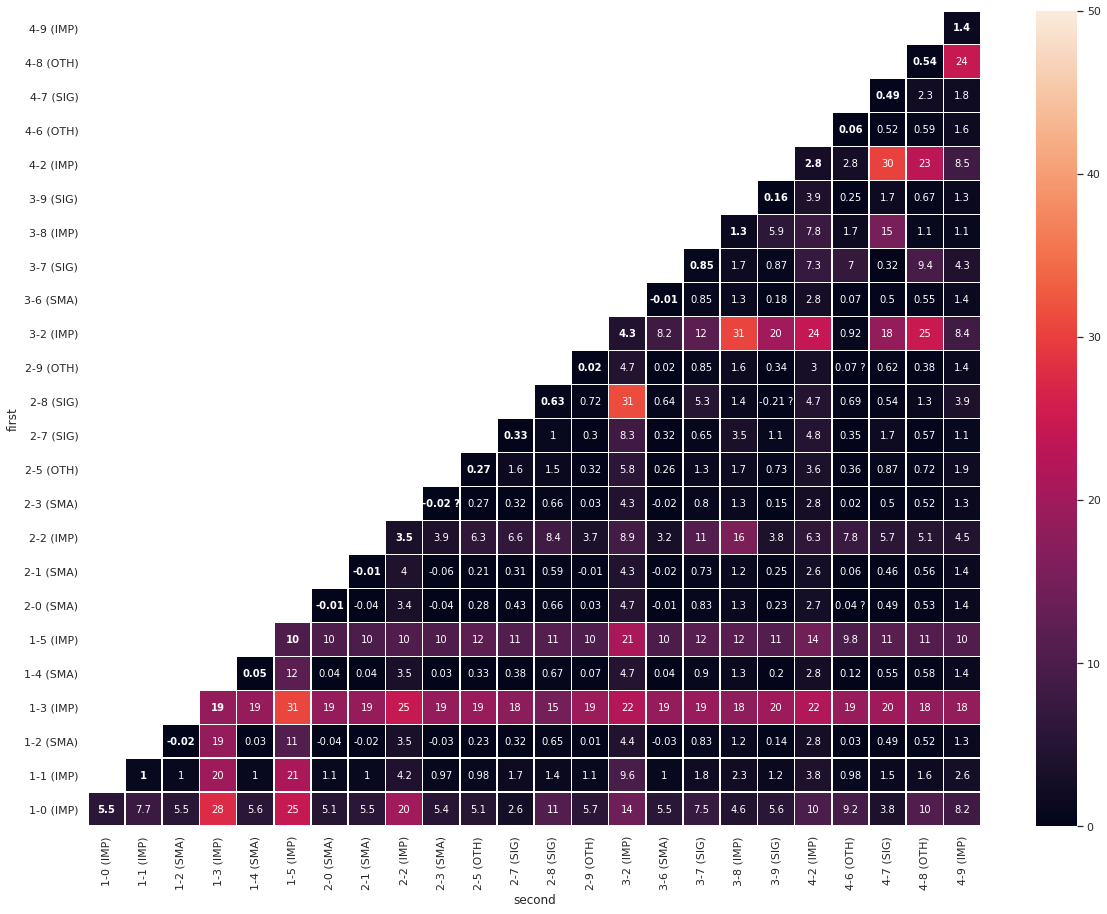

In [18]:
double_joint_diff_mat = -build_double_mat(double_joint_df, single_df, col='diff')

plot_double_heatmap(double_joint_diff_mat, double_joint_df,
                     metadata=joint_metadata, pvalue_threshod=TWO_WAY_PVALUE_THRESHOLD,
                     vmax=50);

### Joint

#### What can we learn from the joint TWBD?

Using the single TWBD prior, with created a taxonomy of clusters, we get the primary division is to important (diff > 1 and significant) and not-important. Let's use this dichotomy to analyze the joint TWBD.

Let's look at layer-cluster X and Y. If we assume that they are both important (as single), we won't be surprised that the joint damaged XY is also important(diff > 1 and significant). Therefore, we should focus on XY if it is not important.

If we assume that X and Y are both *not* important, it would be interesting if the joint damage XY is important. It means that only their combined formation together is impactful.

Finally, considering the case for X is important, and Y is not (without loss of generality), our prior would be that the joint damaged XY will also be important, because of the contribution of X. So not important XY matters in that situation.

To summary up, these are the cases we care about, because they convey information that changes our single TWBD prior:

| X | Y | XY |
|---|---|----|
| ✔️ | ✔️ | ❌  |
| ✔️ | ❌ | ❌  |
| ❌ | ❌ | ✔️  |

In [19]:
from src.lesion.output import build_double_joint_imp_grouped_df

double_joint_imp_df, double_joint_imp_grouped_df = build_double_joint_imp_grouped_df(double_joint_df, single_df)

double_joint_imp_grouped_df

first_is_important  second_is_important  is_important
❌                   ❌                    ❌               108
✔️                  ❌                    ✔️               77
❌                   ✔️                   ✔️               54
✔️                  ✔️                   ✔️               45
❌                   ❌                    ✔️               12
✔️                  ❌                    ❌                 4
dtype: int64

##### Let's iterate on the interesting cases:

We should be REALLY CAREFUL when we look at double damage when both of the clusters come from the same layer. The space of possible shuffles behaves different, so I won't try to come up with observation in these cases.

In [20]:
from collections import Counter

double_joint_interesting_cases = [('✔️', '✔️', '❌'),
                              ('✔️', '❌', '❌'),
                              ('❌', '✔️', '❌'),
                              ('❌', '❌', '✔️')]

is_important_fields = ['first_is_important', 'second_is_important', 'is_important'] 

In [21]:
for interesting_case in double_joint_interesting_cases:
    
    intresting_double_joint_imp_df = (double_joint_imp_df[(double_joint_imp_df[is_important_fields]
                                                   == interesting_case)
                                              .all(axis=1)])

    # same cluster-layer is an anomaly that we should remove (we do so with the heatmap plotting)
    intresting_double_joint_imp_df = intresting_double_joint_imp_df[intresting_double_joint_imp_df['first']
                                                            != intresting_double_joint_imp_df['second']]

    if not intresting_double_joint_imp_df.empty:
        
        print(interesting_case)

        display.display(intresting_double_joint_imp_df.sort_values('diff'))
        
        display.display(Counter(tuple(sorted(v))
                        for v in (intresting_double_joint_imp_df[['first_taxonomy', 'second_taxonomy']]).values))

('✔️', '❌', '❌')


value,labels_in_layers,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,first,second,first_taxonomy,second_taxonomy,is_important,first_is_important,second_is_important
33,"((1, 1), (2, 5))",-0.0098,0.333333,0.8605,sig-but-not-diff,0.87020,0.000000,-inf,"(1, 1)","(2, 5)",important,other,❌,✔️,❌
43,"((1, 1), (4, 6))",-0.0098,0.333333,0.8605,sig-but-not-diff,0.86915,0.001485,-5.825213,"(1, 1)","(4, 6)",important,other,❌,✔️,❌
32,"((1, 1), (2, 3))",-0.0097,0.333333,0.8606,sig-but-not-diff,0.87050,0.000424,-23.334524,"(1, 1)","(2, 3)",important,small,❌,✔️,❌
251,"((3, 2), (4, 6))",-0.0092,0.333333,0.8611,sig-but-not-diff,0.87125,0.001909,-5.316395,"(3, 2)","(4, 6)",important,other,❌,✔️,❌


Counter({('important', 'small'): 1, ('important', 'other'): 3})

('❌', '❌', '✔️')


value,labels_in_layers,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,first,second,first_taxonomy,second_taxonomy,is_important,first_is_important,second_is_important
270,"((3, 7), (4, 8))",-0.0941,0.333333,0.7762,important,0.86865,0.001344,-68.812655,"(3, 7)","(4, 8)",sig-but-not-diff,other,✔️,❌,❌
268,"((3, 7), (4, 6))",-0.0696,0.333333,0.8007,important,0.87005,0.002192,-31.637326,"(3, 7)","(4, 6)",sig-but-not-diff,other,✔️,❌,❌
226,"((2, 8), (3, 7))",-0.0527,0.333333,0.8176,important,0.87100,0.001273,-41.955002,"(2, 8)","(3, 7)",sig-but-not-diff,sig-but-not-diff,✔️,❌,❌
295,"((4, 7), (4, 8))",-0.0226,0.333333,0.8477,important,0.86475,0.000636,-26.791490,"(4, 7)","(4, 8)",sig-but-not-diff,other,✔️,❌,❌
219,"((2, 7), (4, 7))",-0.0175,0.333333,0.8528,important,0.86775,0.000919,-16.263456,"(2, 7)","(4, 7)",sig-but-not-diff,sig-but-not-diff,✔️,❌,❌
282,"((3, 9), (4, 7))",-0.0169,0.333333,0.8534,important,0.86985,0.002333,-7.049640,"(3, 9)","(4, 7)",sig-but-not-diff,sig-but-not-diff,✔️,❌,❌
196,"((2, 5), (2, 7))",-0.0161,0.333333,0.8542,important,0.86865,0.002051,-7.046685,"(2, 5)","(2, 7)",other,sig-but-not-diff,✔️,❌,❌
197,"((2, 5), (2, 8))",-0.0148,0.333333,0.8555,important,0.87040,0.002263,-6.584932,"(2, 5)","(2, 8)",other,sig-but-not-diff,✔️,❌,❌
232,"((2, 8), (4, 8))",-0.0133,0.333333,0.8570,important,0.86530,0.000000,-inf,"(2, 8)","(4, 8)",sig-but-not-diff,other,✔️,❌,❌
201,"((2, 5), (3, 7))",-0.0129,0.333333,0.8574,important,0.87090,0.001980,-6.818530,"(2, 5)","(3, 7)",other,sig-but-not-diff,✔️,❌,❌


Counter({('other', 'sig-but-not-diff'): 7,
         ('sig-but-not-diff', 'sig-but-not-diff'): 5})

It is hard to come up with a firm conclusions, but we can clearly see that in that pattern, "almost" important layer-cluster (diff-but-sig or sig-but-diff) is hitting the important criterion with the help of another layer-cluster.

One tempting interpretation, if we continue our previous line of reasoning until now, is that we found a higher-level clustering. These two layer-clusters should be grouped together. However, while the single BDT and its taxonomy are based on spectral clustering, and it is justified by the static structure (stronger weights inside a cluster compared to outside), this is not the case here.

An alternative explanation could be that we grouped with joint TWBDT two unrelated layer-clusters, so we did damage in two different "functions"; therefore, it a sign for a separate grouping. 


By the joint TWBDt experiment, we cannot distinguish the two possible explanations; therefore, we'll turn to another method to perform double BDT, which helps us to discover dependencies (in the sense of information flow) between layer-clusters).

### Conditional - $first|second$

* Difference - As in joint $Diff_{first,second}$
* P-value - Fix the *second* layer-cluster and shuffle the *first*

In [ ]:
if MODE == 'STORE':
    (conditional_true_results,
     conditional_all_random_results,
     conditional_metadata,
     conditional_evaluation) = perform_lesion_experiment('.' + DATA_PATHS[DATASET_NAME],
                                                   model_path,
                                                   n_clusters=N_CLUSTERS,
                                                   n_shuffles=TWO_WAY_N_SHUFFLES,
                                                   n_way=2,
                                                   n_way_type='conditional',
                                                   with_random=True,
                                                   verbose=True)

Single worker!
Loading data...
Running spectral clustering...
Loading model and extracting weights...
Evaluate original model...
Extract metadata...
Apply lesion trial on the true clustering...


In [43]:
if MODE == 'STORE':
    double_conditional_df = compute_damaged_cluster_stats(conditional_true_results,
                                                           conditional_all_random_results,
                                                           conditional_metadata,
                                                           conditional_evaluation,
                                                           double_joint_df=double_joint_df,
                                                           single_df=single_df,
                                                           diff_field='s_i|j')

    double_conditional_df = enrich_score_double_conditional_df(double_conditional_df, single_df)


double_conditional_df.head()

../src/lesion/output.py:169: UserWarning: Make sure that `n_shuffled` for conditional double results should be the same as the one for generating the joint double df!
  warnings.warn('Make sure that `n_shuffled` for conditional double results should be the same'


value,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,s_i|j
labels_in_layers,,,,,,,,
"((1, 0), (1, 0))",-0.0552,0.333333,0.8151,important,0.866450,0.002051,-25.041333,-0.0552
"((1, 0), (1, 1))",-0.0768,0.019608,0.7935,important,0.856518,0.003609,-17.459779,-0.0663
"((1, 0), (1, 2))",-0.0551,0.019608,0.8152,important,0.866460,0.002554,-20.068057,-0.0553
"((1, 0), (1, 3))",-0.2766,0.019608,0.5937,important,0.677076,0.005280,-15.789813,-0.0896
"((1, 0), (1, 4))",-0.0556,0.019608,0.8147,important,0.865690,0.002152,-23.699413,-0.0551


Let's plot on heatmap the results:
* Rows: First ("shuffled") layer cluster
* Columns: Second ("fixed"/"conditioned") layer-cluster
* Cells: Difference of true layter-cluster (number) as well as significance (★)

Of course, the matrix will be symmetric concerning the difference; however, the significance won't be necessary symmetric.

The diagonal represents the single BDT. 

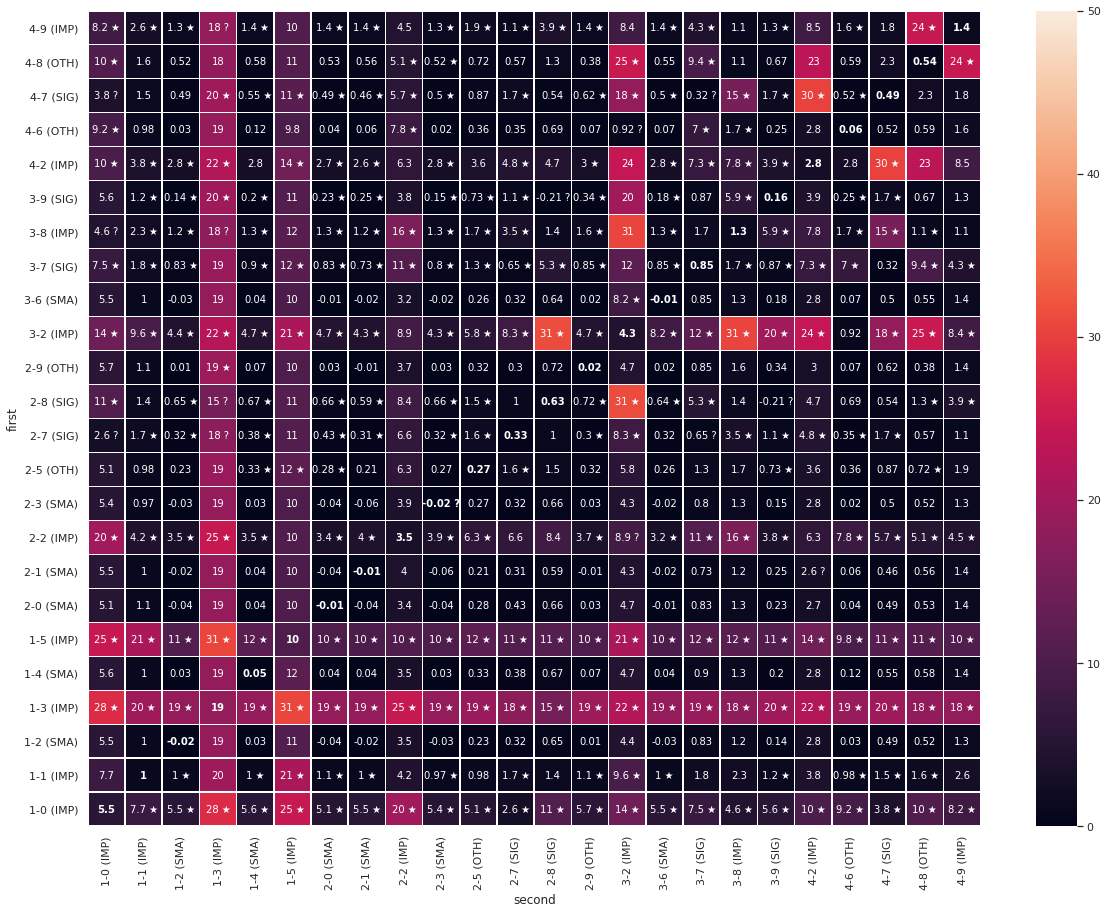

In [44]:
double_conditional_true_mat = -build_double_mat(double_conditional_df, single_df, col='diff')

plot_double_heatmap(double_conditional_true_mat, double_conditional_df, is_trig=False,
                     metadata=conditional_metadata, pvalue_threshod=TWO_WAY_PVALUE_THRESHOLD,
                     vmax=50);

#### We can look also into the $s_{i|j}$ - which was used to define the taxonomy (see remark later):

## $s_{i|j} = Diff_{ij} - Diff_{j} = (Acc - Acc_{ij}) - (Acc - Acc_{j}) = Acc_{j} - Acc_{ij}$

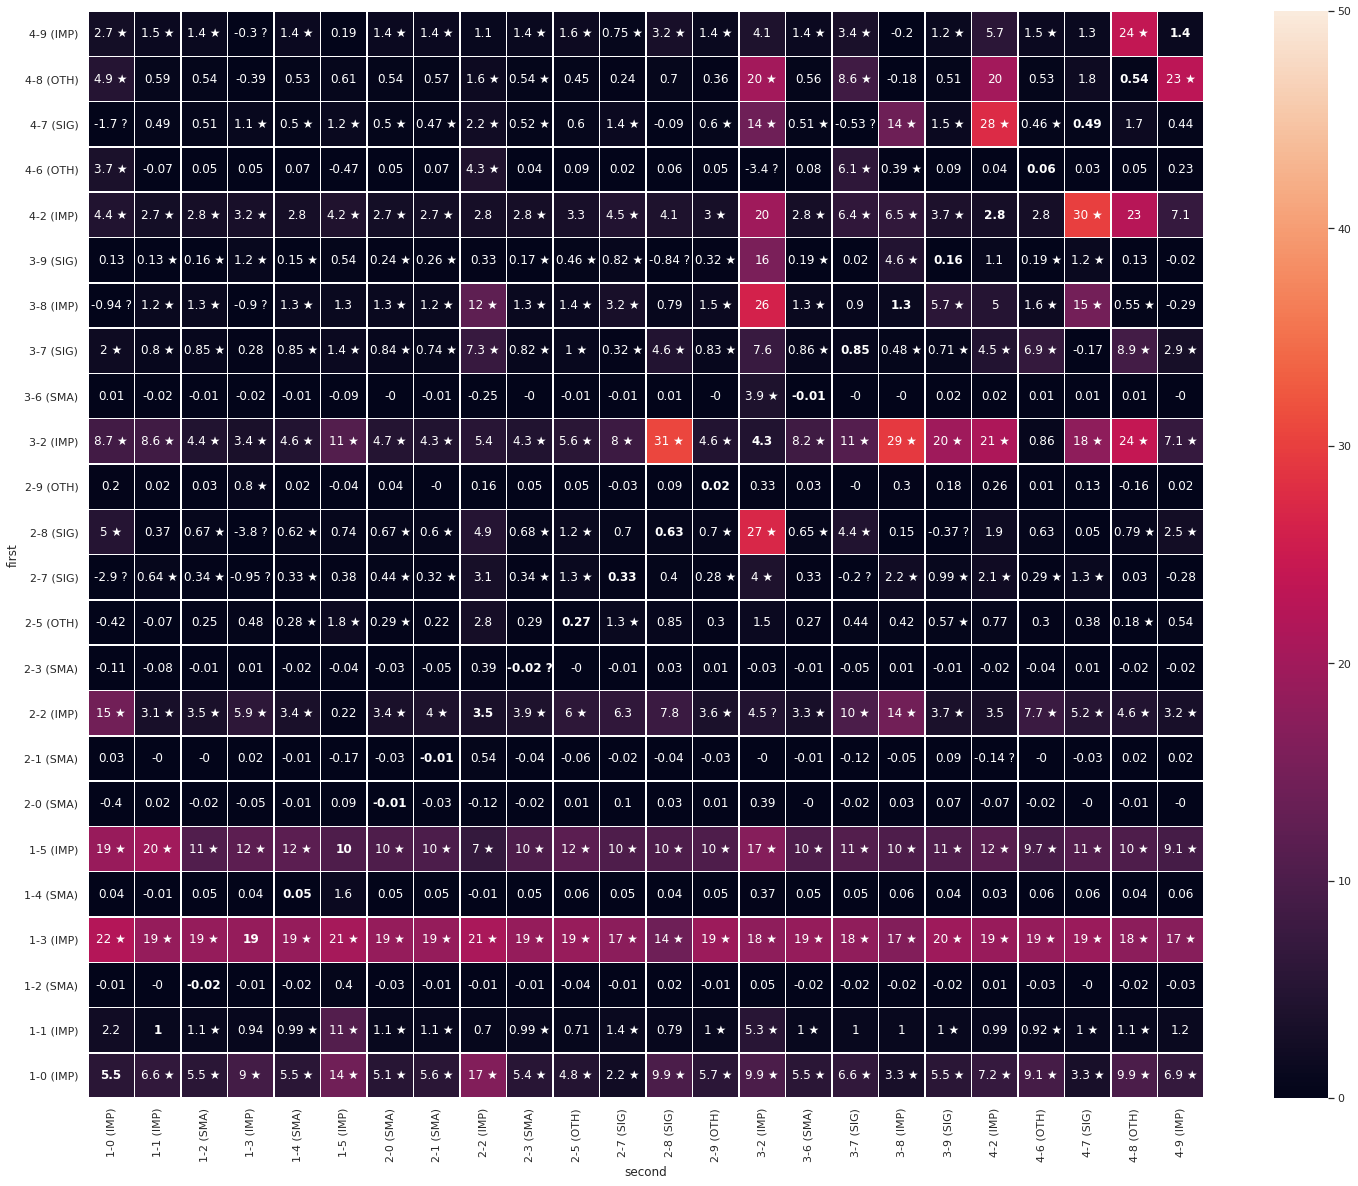

In [284]:
sns.set(font_scale=1)

tw_cond_sij_mat = -build_double_mat(double_conditional_df, single_df, col='s_i|j')

plot_double_heatmap(tw_cond_sij_mat, double_conditional_df, is_trig=False,
                     metadata=conditional_metadata, pvalue_threshod=TWO_WAY_PVALUE_THRESHOLD,
                     vmax=50, figsize=(25, 20), diag_font_size=12);

#plt.savefig('../plots/mlp-double-lestion-test-deltas-with-sig.png', dpi=300)

sns.set(font_scale=1.5)

In [285]:
# import itertools as it
# in_layer_mask = np.reshape([first_layer_id == second_layer_id and first_cluster_id != second_cluster_id
#  for (first_layer_id, first_cluster_id), (second_layer_id, second_cluster_id)
#     in it.product(tw_cond_sij_mat.columns.str[:3].str.split('-'),
#            tw_cond_sij_mat.index.str[:3].str.split('-'))],
#          tw_cond_sij_mat.shape)

# tw_cond_sij_mat[in_layer_mask] = np.nan

# plot_double_heatmap(tw_cond_sij_mat, double_conditional_df, is_trig=False,
#                     metadata=conditional_metadata, pvalue_threshod=TWO_WAY_PVALUE_THRESHOLD,
#                      vmax=50, figsize=(25, 20), diag_font_size=12);

### Remark & TODO: Integrate into notebook, not as contra to `diff`

Let's look at the case of `X -> Y`, where both X and Y are *important* single layer-cluster.
If we damage Y, then the output of X won't have any impact.
So `d_Y ≈ d_XY` (or `s_X|Y ≈ 0`).
The opposite argument gives us `d_X ≈ d_XY` (or `s_Y|X ≈ 0`).

I defined an *important conditional* damage X|Y by these two necessary conditions:
1. `d_XY > 1%`
2. The p-value (damaging X while fixing Y) is minimal, i.e., `1 / (#shuffles + 1)`. In other words, `d_XY` is bigger than `d_ZY` for all (sampled) random shuffles of X (here Z).

Now, I'd argue that condition (1) indeed doesn't make sense, but (2) is totally fine.

First, the "importance" of a conditional damage `X|Y` should be defined in terms of `s_X|Y` and not `d_XY`. The latter is dependent on the impact of Y, which we would like to remove, while `s_X|Y` takes it into account. So a better first condition would be `s_X|Y > 1%`, i.e., the additional damage of X on top of Y is at least 1% of accuracy.

Second, recall that we are focusing on the case of `X -> Y`. Assume we damage Y. Damaging X won't increase the damage of Y ( `s_X|Y ≈ 0`), while any other random shuffle Z might contain other neurons that influence other neurons in the layer of Y.
**So, they will have a bigger difference, and we would have p-value equals to 1!**
However, all the four types of influence (such as `X -> Y`) are *idealized*, and X probably influences on other neurons in the layer of Y, so we introduce some noise to the calculated accuracy. Therefore, we won't get precisely one for p-value.
A prediction we can make here is that the standard deviation would be relatively small, and **we should check it**.

This line of argumentation works as well for the `Y|X` damage, and other types of `(X|Y, Y|X)` combinations.

#### We can also explore the relationship between `s_i|j` and `diff`. Keep in mind the taxonomy is based on `s_i|j`.

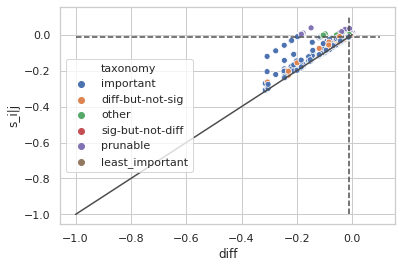

In [46]:
sns.scatterplot(x='diff', y='s_i|j', hue='taxonomy', data=double_conditional_df);
plt.plot([-1, 0], [-1, 0], ls='-', c='.3');
plt.plot([-0.01, -0.01], [-1, 0.1], ls='--', c='.3');
plt.plot([-1, 0.1], [-0.01, -0.01], ls='--', c='.3');

As we could expect, there is a linear relationship between the two metrics. The different "parallel" lines are probably coming from different layer-cluster we conditioned on them because it set the offset (because $diff_j$ is fixed.

#### Let's see if we get $s_{i|j}$ > 1% with p-value = 1 (called `least_important` in the taxonomy):

In [47]:
double_conditional_df['taxonomy'].value_counts()

other               243
important           213
sig-but-not-diff     70
diff-but-not-sig     35
prunable             14
least_important       1
Name: taxonomy, dtype: int64

In [48]:
double_conditional_df[double_conditional_df['taxonomy'] == 'least_important']

value,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,s_i|j
labels_in_layers,,,,,,,,
"((2, 2), (3, 2))",-0.0887,1.0,0.7816,least_important,0.715256,0.033433,1.984402,-0.0454


### How can we use conditional TWBDT? Discovering Dependencies!

Suppose we have two layer-cluster $X$ and $Y$, where $X$ is in an earlier layer then $Y$. We will assume that both of them are *important* by the single BDT (diff. and sig.).

Let's focus only on *important* layer-clusters, because we know by the single BDT that they are important to the functioning of the network.

We will say that a layter-cluster $Y$ is *depended* on layer-cluster $X$ if there is a *flow of information* from $X$ to $Y$, i.e. the values of $X$ are required for computing $Y$. We will show it as:

$$X \rightarrow Y$$

(⚠️ We need a better formalization!)

#### There are four kind of possible (idealistic) dependencies, whether there are additional involved layer-clusters ($Z$ and $Z'$):

![](imgs/ctwbd-dependencies.jpg)

#### How will conditional TWBDT behave?
(keep in mind, both $X$ and $Y$ are important)

| Type | X\|Y | Y\|X | Why? |
|------|-----|-----|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| I | ❌ | ❌ | All the (information) output of X goes to Y, and all of the (information) input of Y comes from X. So they are tied together, and damage in one for them will be equivalent to damage the other one. |
| II | ✔️ | ❌ | Damaging X will block already all the input of Y, so no additional impact for damaging Y afterwords. However, Z gets input from X independently, so only conditioning on Y won't block all the information from X. |
| III | ❌ | ✔️ | The opposite argument from the previous row holds. |
| IV | ✔️ | ✔️ | Both of the two previous arguments hold. |

**We cannot learn anything from the last type IV**, because it will have the same behavior as no flow of information between $X$ and $Y$. Therefore, we care only about the first three types. It does make sense because, by our prior (single BDT), we should be "surprised" if a layer-cluster stops to be important.

In [49]:
from src.lesion.output import build_tw_cond_imp_merged_df

tw_cond_imp_df = build_tw_cond_imp_merged_df(double_conditional_df, single_df)

In [179]:
tw_cond_imp_df['X|Y'] = tw_cond_imp_df['X|Y'].replace({True: '✓', False: '✗'})
tw_cond_imp_df['Y|X'] = tw_cond_imp_df['Y|X'].replace({True: '✓', False: '✗'})

In [134]:
tw_cond_imp_df

value,sorted,X|Y,Y|X,s_X|Y,s_Y|X
0,"((1, 0), (2, 2))",✓,✓,-0.1660,-0.1458
1,"((1, 0), (3, 2))",✓,✓,-0.0992,-0.0873
2,"((1, 0), (3, 8))",✓,✗,-0.0331,0.0094
3,"((1, 0), (4, 2))",✓,✓,-0.0717,-0.0444
4,"((1, 0), (4, 9))",✓,✓,-0.0686,-0.0270
5,"((1, 1), (2, 2))",✗,✓,-0.0070,-0.0315
6,"((1, 1), (3, 2))",✓,✓,-0.0528,-0.0856
7,"((1, 1), (3, 8))",✗,✓,-0.0102,-0.0124
8,"((1, 1), (4, 2))",✗,✓,-0.0099,-0.0273
9,"((1, 1), (4, 9))",✗,✓,-0.0124,-0.0155


In [227]:
tw_cond_imp_df.to_csv('../results/mlp-double-lesion-test-conditional-important-pairs-publication.csv')

This a count for every type:

In [136]:
tw_cond_imp_df.groupby(['X|Y', 'Y|X']).size()

X|Y  Y|X
✓    ✓      11
     ✗       9
✗    ✓       5
     ✗       3
dtype: int64

Let's see how $s_{i|j}$ is influnced by the type:

-5.939999999999996 26.410000000000007


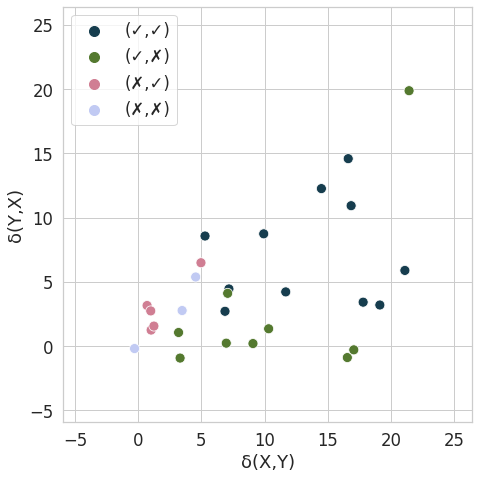

In [224]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

tw_cond_imp_type = ('(' + (tw_cond_imp_df['X|Y'].astype(str) + ',' + tw_cond_imp_df['Y|X'].astype(str)) + ')').values

mostly_positive_tw_cond_imp_df = tw_cond_imp_df.copy()
mostly_positive_tw_cond_imp_df['s_X|Y'] = -mostly_positive_tw_cond_imp_df['s_X|Y']
mostly_positive_tw_cond_imp_df['s_Y|X'] = -mostly_positive_tw_cond_imp_df['s_Y|X']

f, ax = plt.subplots(1, figsize=(7, 7))

palette = sns.color_palette('cubehelix', 4)

g = sns.scatterplot(mostly_positive_tw_cond_imp_df['s_X|Y']*100,
                    mostly_positive_tw_cond_imp_df['s_Y|X']*100,
                     hue=tw_cond_imp_type,
                    palette=palette,
                     s=100)


for lh in g.legend_.legendHandles: 
    lh._sizes = [100] 

sij_min, sij_max = (mostly_positive_tw_cond_imp_df[['s_X|Y', 's_Y|X']].min().min() * 100 - 5,
                    mostly_positive_tw_cond_imp_df[['s_X|Y', 's_Y|X']].max().max() * 100 + 5)
#sij_min += 10
print(sij_min, sij_max)
g.axis([sij_min, sij_max, sij_min, sij_max]);

plt.xlabel('δ(X,Y)')
plt.ylabel('δ(Y,X)')

plt.tight_layout()


plt.savefig('../plots/mlp-double-test-deltas.png', dpi=300)

In [219]:
mostly_positive_tw_cond_imp_df[['s_X|Y', 's_Y|X']].max().max()

0.21410000000000007

In [207]:
-tw_cond_imp_df['s_X|Y']*100,


(0     16.60
 1      9.92
 2      3.31
 3      7.17
 4      6.86
 5      0.70
 6      5.28
 7      1.02
 8      0.99
 9      1.24
 10    21.08
 11    17.78
 12    16.53
 13    19.10
 14    17.04
 15     6.96
 16    16.83
 17    10.31
 18    11.66
 19     9.07
 20     4.54
 21    14.48
 22     3.47
 23     3.19
 24    21.41
 25     7.07
 26     4.96
 27    -0.29
 Name: s_X|Y, dtype: float64,)

-0.21410000000000007

Let's take only Type I, II and II: There is at least one False for X|Y and Y|X:

In [158]:
tw_cond_imp_df['X|Y'] = tw_cond_imp_df['X|Y'].replace({'✓': True, '✗': False})
tw_cond_imp_df['Y|X'] = tw_cond_imp_df['Y|X'].replace({'✓': True, '✗': False})

TypeError: Cannot compare types 'ndarray(dtype=bool)' and 'str'

In [160]:
dependency_type_mask

0     False
1     False
2     False
3     False
4     False
5      True
6     False
7      True
8      True
9      True
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20     True
21    False
22     True
23    False
24    False
25    False
26     True
27     True
dtype: bool

In [159]:
tw_cond_imp_df

value,sorted,X|Y,Y|X,s_X|Y,s_Y|X
0,"((1, 0), (2, 2))",True,True,-0.1660,-0.1458
1,"((1, 0), (3, 2))",True,True,-0.0992,-0.0873
2,"((1, 0), (3, 8))",True,False,-0.0331,0.0094
3,"((1, 0), (4, 2))",True,True,-0.0717,-0.0444
4,"((1, 0), (4, 9))",True,True,-0.0686,-0.0270
5,"((1, 1), (2, 2))",False,True,-0.0070,-0.0315
6,"((1, 1), (3, 2))",True,True,-0.0528,-0.0856
7,"((1, 1), (3, 8))",False,True,-0.0102,-0.0124
8,"((1, 1), (4, 2))",False,True,-0.0099,-0.0273
9,"((1, 1), (4, 9))",False,True,-0.0124,-0.0155


['1-0', '1-1', '1-3', '1-5', '2-2', '3-2', '3-8', '4-2', '4-9']
[('1-0', '3-8'), ('1-1', '2-2'), ('1-1', '3-8'), ('1-1', '4-2'), ('1-1', '4-9'), ('1-3', '3-8'), ('1-3', '4-9'), ('1-5', '2-2'), ('1-5', '3-8'), ('1-5', '4-9'), ('2-2', '3-2'), ('2-2', '4-2'), ('2-2', '4-9'), ('3-2', '4-2'), ('3-2', '4-9'), ('3-8', '4-2'), ('3-8', '4-9')]


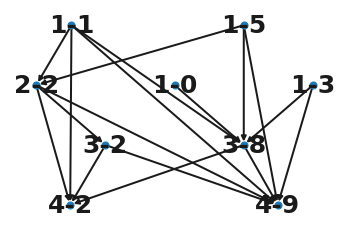

In [163]:
from src.lesion.output import draw_tw_cond_dependency_graph

if tw_cond_imp_df.shape[0] > 0:
    draw_tw_cond_dependency_graph(tw_cond_imp_df, single_df);

### For comparison, let's see the "dependency" graph by the strongest weight (absolute sum) path between two layers

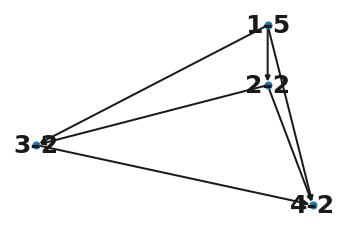

In [54]:
one_way_weighted_dist_mat = build_weighted_dist_mat(model_path, one_way_clustering_result)

draw_ow_weight_dependency_graph(one_way_weighted_dist_mat);

### Although the two graphs have shared edges, they are not the same, and they capture different stuff.

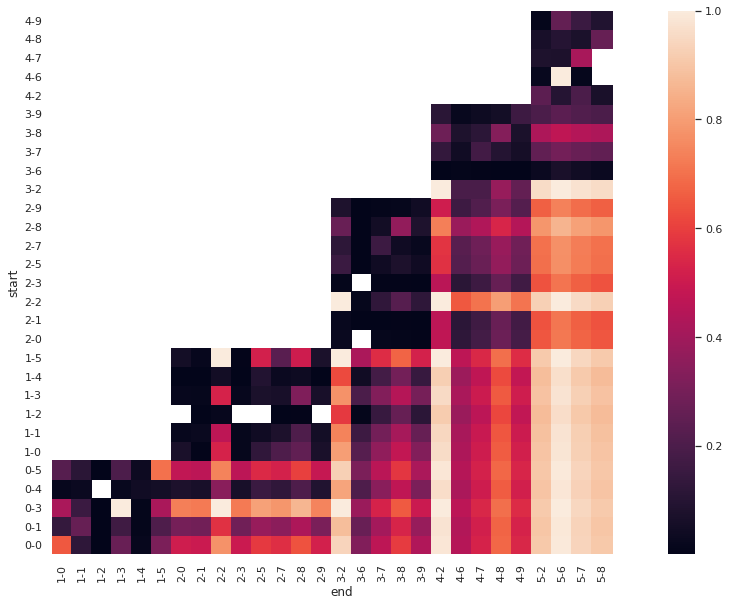

In [55]:
plot_weighted_dist_mat(one_way_weighted_dist_mat);

### IGNORE ME - IT IS MORE COMPLEX THAN IT SEEMS
### Validation: Transitivity

We can try to valdidate our dependency graph, by checking whether it is transitive:

#### If
$$
X \rightarrow Z \rightarrow Y
$$

### Then

$$
X \rightarrow Y
$$

### Store Data

In [91]:
if MODE == 'STORE':
    with open(PICKLE_PATH, 'wb') as f:
        pickle.dump((N_CLUSTERS, single_df,
                     TWO_WAY_N_SHUFFLES, TWO_WAY_PVALUE_THRESHOLD,
                     double_joint_df, joint_metadata,
                     double_conditional_df, conditional_metadata),
                   f)